In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [19]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

Loading data...
Done!


In [25]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [26]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [27]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [28]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

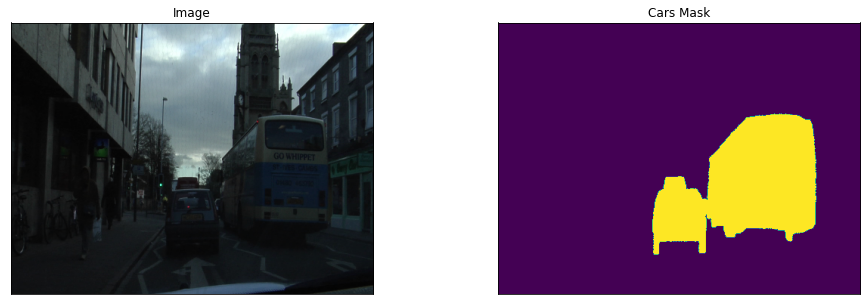

In [29]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [48]:
# !pip install --user albumentations

  Using cached albumentations-1.1.0-py3-none-any.whl (102 kB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  Using cached opencv_python_headless-4.5.5.64-cp36-abi3-win_amd64.whl (35.3 MB)


In [30]:
import albumentations as albu

In [32]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [33]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['car'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

RuntimeError: You are trying to use a deprecated augmentation 'IAAAdditiveGaussianNoise' which depends on the imgaug library, but imgaug is not installed.

There are two options to fix this error:
1. [Recommended]. Switch to the Albumentations' implementation of the augmentation with the same API: GaussNoise - https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.GaussNoise
2. Install a version of Albumentations that contains imgaug by running 'pip install -U albumentations[imgaug]'.

In [13]:
from torch.utils.data import DataLoader
from torchvision import transforms

batch_size = 5
data_tr = DataLoader(dataset = tr, 
                     batch_size = batch_size,
                     shuffle = True) 
data_val = DataLoader(dataset = val, 
                     batch_size = batch_size,
                     shuffle = False) 
data_ts = DataLoader(dataset = ts, 
                     batch_size = batch_size,
                     shuffle = False) 

In [14]:
dataloaders = {}
dataloaders['train'], dataloaders['val'], dataloaders['test'] = data_tr, data_val, data_ts

In [16]:
import torch
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.9.1  Device: cuda


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
#from torchsummary import summary

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [21]:
def dice_loss(targets, inputs):
    
    smooth=1e-6
    inputs = torch.flatten(torch.sigmoid(inputs))
    targets = torch.flatten(targets)
    
    intersection = torch.sum(inputs * targets)
    cardinality = torch.sum(inputs + targets)
    
    dice_score = 2. * intersection / (cardinality + smooth)
    return torch.mean(1. - dice_score)

In [22]:
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU()
                                        ])
        self.pool0 =  nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                        ])
        self.pool1 =  nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True)# 128 -> 64
        self.enc_conv2 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                        ])
        self.pool2 =  nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True)# 64 -> 32
        self.enc_conv3 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                         ])
        self.pool3 =  nn.MaxPool2d(kernel_size=(2,2), stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        # чет без понятия как реализовать все в одном self.bottleneck
        #self.bottleneck
        self.bottleneck_conv_enc = nn.Sequential(*[
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                         ])

        self.bottleneck_pool = nn.MaxPool2d(kernel_size=(2,2), stride=2, return_indices=True)


        self.bottleneck_upsample = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.bottleneck_conv_dec = nn.Sequential(*[
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),     
                                         nn.ReLU()
                                         ])


        # decoder (upsampling)
        self.upsample0 =  nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                         ]) 
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                         ]) 
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU()
                                         ]) 
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
                            
                                         ]) 

    def forward(self, x):
        # encoder

        size_0 = x.size()
        e0, id0 = self.pool0(self.enc_conv0(x))
        
        size_1 = e0.size()
        e1, id1 = self.pool1(self.enc_conv1(e0))

        size_2 = e1.size()
        e2, id2 = self.pool2(self.enc_conv2(e1))

        size_3 = e2.size()
        e3, id3 = self.pool3(self.enc_conv3(e2))
        # bottleneck

        #bottleneck encoder part
        size_4 = e3.size()
        bottle_enc, bottle_id = self.bottleneck_pool(self.bottleneck_conv_enc(e3))
        #bottleneck decoder part
        size_d = bottle_enc.size()

        bottle_dec = self.bottleneck_conv_dec(self.bottleneck_upsample(bottle_enc, bottle_id, output_size=size_4))

#         # decoder

        d0 = self.dec_conv0(self.upsample0(bottle_dec, id3, output_size=size_3))
    
        d1 = self.dec_conv1(self.upsample1(d0, id2, output_size=size_2))

        d2 = self.dec_conv2(self.upsample2(d1, id1, output_size=size_1))
        d3 = self.dec_conv3(self.upsample3(d2, id0, output_size=size_0))  # no activation
        return d3

In [19]:
import time
import copy
import seaborn as sns
import gc

In [25]:
def train_new(model, optimizer, loss_fn, epochs, data):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_iou = 0.0
    
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_train_iou = []
    epoch_val_iou = []
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)
    
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_iou = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    Y_pred = model(inputs)
                    loss = loss_fn(labels, Y_pred)
                    
                    # forward-pass
                    if phase == 'train':
                        loss.backward()  # backward-pass
                        optimizer.step()

                running_loss += loss.detach().item() * inputs.size(0)
                Y_pred = torch.sigmoid(Y_pred)
                Y_pred = torch.where(Y_pred > 0.5, 1, 0)
                running_iou += iou_pytorch(Y_pred, labels).mean().item()
                
            
            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_iou = running_iou / len(dataloaders[phase])
            
            if phase == 'train':
                epoch_train_loss.append(epoch_loss)
                epoch_train_iou.append(epoch_iou)
            else:
                epoch_val_loss.append(epoch_loss)
                epoch_val_iou.append(epoch_iou)
                

#             print('{} Loss: {:.4f} IOU: {:.4f}'.format(
#                     phase, epoch_loss, epoch_iou))
            
            if phase == 'val':
                Y_pred = Y_pred.detach().cpu()
                clear_output(wait=True)
                for k in range(5):
                    plt.subplot(2, 5, k+1)
                    plt.imshow(np.rollaxis(inputs[k].cpu().numpy(), 0, 3), cmap='gray')
                    plt.title('Real', fontsize=12)
                    
                    plt.axis('off')

                    plt.subplot(2, 5, k+6)
                    plt.imshow(Y_pred[k, 0], cmap='gray')
                    plt.title('Output', fontsize=12)
                    plt.axis('off')
                plt.suptitle('val Loss: {:.4f} val IOU: {:.4f}'.format(epoch_loss, epoch_iou), fontsize=15)
                plt.show()
                
            inputs, labels = inputs.cpu(), labels.cpu()
            Y_pred, loss = Y_pred.cpu(), loss.cpu()
            #running_loss, running_iou = running_loss.cpu(), running_iou.cpu()
            #epoch_loss, epoch_iou = epoch_loss.cpu(), epoch_iou.cpu()
            del inputs, labels, Y_pred, loss, #running_loss, running_iou, epoch_loss, epoch_iou
            torch.cuda.empty_cache()
            gc.collect()
            
            
            if phase == 'val' and epoch_iou > best_iou:
                best_iou = epoch_iou
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val IOU: {:4f}'.format(best_iou))
    
    
    model.load_state_dict(best_model_wts)
    statistics = epoch_train_loss, epoch_train_iou, epoch_val_loss, epoch_val_iou
    #torch.save(model.state_dict(), '/')
    return model, statistics

In [ ]:
dataloaders['']

In [26]:
model_dice = SegNet().to(DEVICE)

max_epochs = 10
optimizer = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
segnet_best_model_dice, segnet_statistics_with_dice_loss = train_new(model_dice, optimizer, dice_loss, max_epochs, dataloaders)

Epoch 1/10
----------


ValueError: too many values to unpack (expected 2)

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)


plt.figure(figsize=(10, 5))
plt.title("Train/val losses")
plt.plot(range(max_epochs), segnet_statistics_with_dice_loss[0], label="train_loss", linewidth=2)
plt.plot(range(max_epochs), segnet_statistics_with_dice_loss[2], label="val_loss", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()


plt.figure(figsize=(10, 5))
plt.title("Train/val IOU")
plt.plot(range(max_epochs), segnet_statistics_with_dice_loss[1], label="train_iou", linewidth=2)
plt.plot(range(max_epochs), segnet_statistics_with_dice_loss[3], label="val_iou", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()